# Singular Value Decomposition of Eccentric Waveforms

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from pycbc.types import timeseries, frequencyseries
from calcwf import gen_wf, chirp2total, shifted_f, shifted_e, gen_psd, ceiltwo, trim_wf, overlap_cplx_wfs, get_h

/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


We can use singular value decomposition (SVD) to generate orthogonal harmonics describing an eccentric waveform. These harmonics are optimal in the sense that information is maximised in the fundamental, then the first harmonic, and so on.

In [2]:
# Parameters
f_low = 10
f_low_psd = 20
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

## Generating training waveforms

We must first generate a basis of 'training' waveforms. The SVD will combine these to create the harmonics. We find varying the phase values of the training waveforms to have no effect on the results, and so for simplicity generate a set of waveforms uniformly spaced in mean anomaly at a fixed time before merger but with the same phase.

In [3]:
# Generates n training waveforms equally spaced in mean anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = -np.angle(overlap)/2
            h *= np.exp(2*1j*phase_angle)
            h = trim_wf(h, training_wfs[0])
            h.resize(ceiltwo(max(len(h), len(training_wfs[0]))))
        else:
            h.resize(ceiltwo(len(h)))   
        
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [4]:
training_wfs = gen_training_wfs(f_low, e, chirp2total(chirp, q), q, 100, sample_rate, 'TEOBResumS')

100 done out of 100.

We will also whiten these waveforms with the LIGO sensitivity curve (aLIGOZeroDetHighPower) in order to appropriately weight frequencies that LIGO is sensitive to. This is important for estimating the fraction of information available in each harmonic, however equivalent results can be found using unwhitened training waveforms.

In [5]:
# Whitens waveforms
def whiten_wfs(wfs, f_low):

    # Generate psd
    psd = gen_psd(wfs[0], f_low)
    delta_f = psd.delta_f

    # Set zero values to 1 (effectively infinity)
    psd = np.array(psd)
    psd[psd==0]=1
    psd = frequencyseries.FrequencySeries(psd, delta_f)

    # Whiten each wf
    whiten = []
    for wf in wfs:
        hp = (wf.real().to_frequencyseries() / psd ** 0.5).to_timeseries()
        hc = (-wf.imag().to_frequencyseries() / psd ** 0.5).to_timeseries()
        whiten.append(hp-1j*hc)

    return whiten

In [6]:
white_training_wfs_20 = whiten_wfs(training_wfs, f_low_psd)

## Performing SVD

SVD is described by the following equation.

$$
\mathbf{X} = \mathbf{U}^*\mathbf{S}\mathbf{V},
$$

$\mathbf{X}$ is the complex $n \times M$ matrix consisting of the training waveforms, $\mathbf{U}$ is a complex $n \times n$ unitary matrix containing the coefficients used to express the calculated harmonics in terms of the input training waveforms, $\mathbf{S}$ is a $n \times M$ rectangular diagonal matrix of real positive numbers describing the relative amount of information each harmonic contains, and $\mathbf{V}$ is a complex $M\times M$ unitary matrix containing the harmonics calculated by the SVD.

In [7]:
# Convert training wf data to np array in right shape/form and calculate svd
start = time.time()
X = np.array(white_training_wfs_20)
means = X.mean(axis=1)
stds = X.std(axis=1)
Uh, S, V = np.linalg.svd(((X.T-means)/stds).T)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 94.92155885696411 seconds


## Examining results

### Plotting SVD harmonics

$\mathbf{V}$ here contains the whitened harmonics, whereas we would like to plot the unwhitened versions. We can find these simply by replacing $\mathbf{X}$ above by the unwhitened training waveforms, and solving for $\mathbf{V}$.

$$
\mathbf{V} = \mathbf{S}^{+}\mathbf{U}\mathbf{X}
$$

$\mathbf{S}^{+}$ here is the pseudo-inverse of $\mathbf{S}$.

In [8]:
# Calculate complex coefficients to combine unwhitened training waveforms
inv_S = 1/S
U = np.conj(Uh).T
inv_S_U = np.matmul(np.diag(inv_S), U)

# Calculate unwhitened harmonics
unwhite_harms = np.matmul(inv_S_U, np.array(training_wfs))

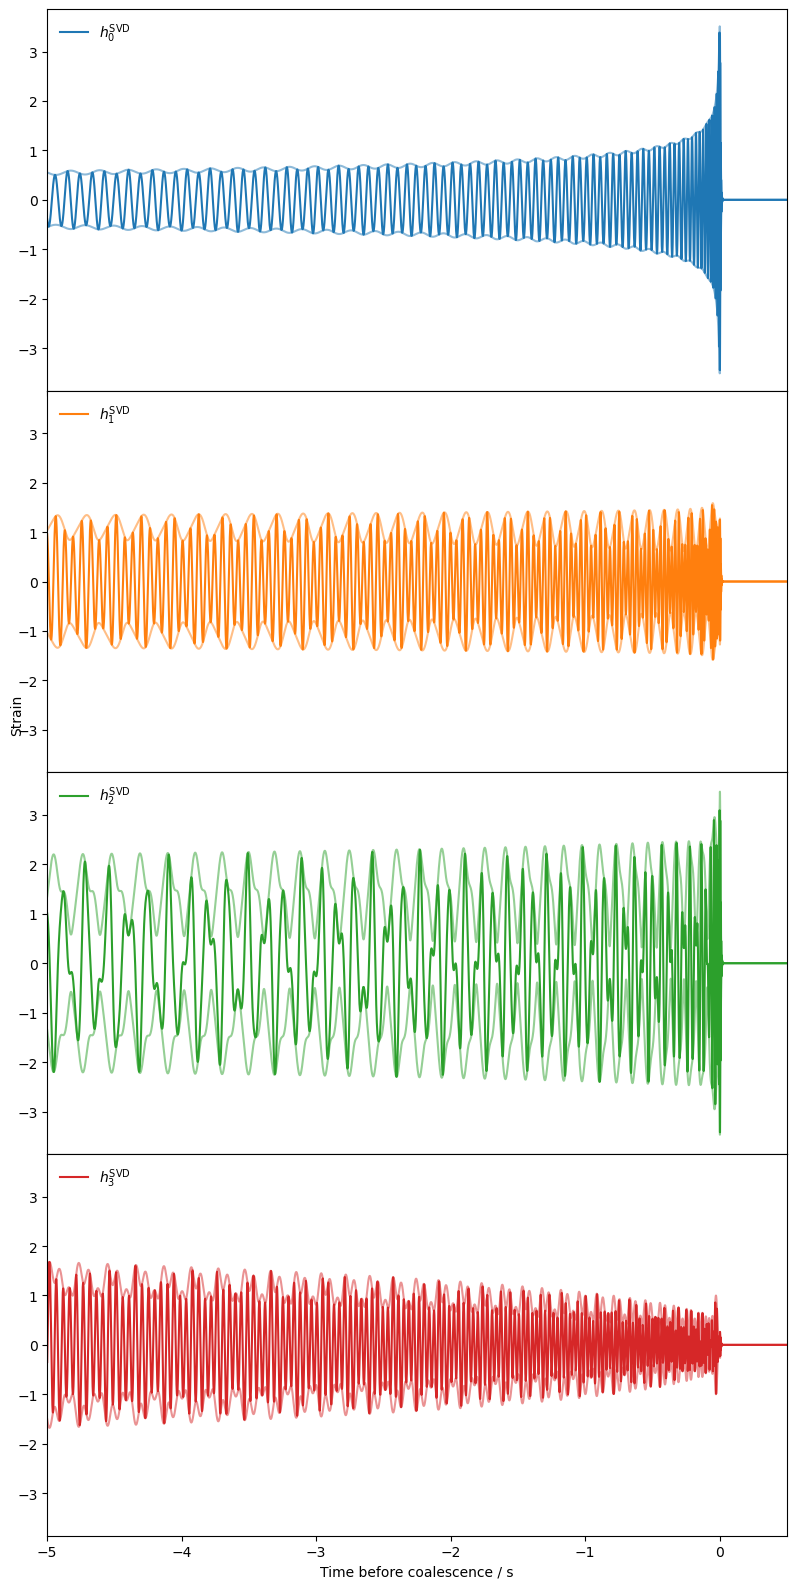

In [9]:
# Make plot of unwhitened harmonics
n_wfs = 4
f = plt.figure(figsize=(8, n_wfs*4))
f.subplots(n_wfs, 1, sharex=True)
for i in range(n_wfs):
    plt.subplot(n_wfs, 1, i+1, )
    plt.plot(training_wfs[0].sample_times, np.real(unwhite_harms[i])*1e21, c='C%i' %i, label='$h_{%s}^\mathrm{SVD}$' % i)
    plt.plot(training_wfs[0].sample_times, abs(unwhite_harms[i])*1e21, c='C%i' %i, alpha=0.5)
    plt.plot(training_wfs[0].sample_times, -abs(unwhite_harms[i])*1e21, c='C%i' %i, alpha=0.5)
    plt.xlim(-5,0.5)
    if i == 0:
        ylims = plt.gca().get_ylim()
    plt.ylim(ylims)
    plt.legend(loc='upper left', frameon=False)
    
plt.gcf().text(0.01, 0.55, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time before coalescence / s')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('Figures/SVD100_h_%d_png' % n_wfs, dpi=450)

### Relative importance

Next, we can calculate the relative importance of each harmonic from $\mathbf{S}$ using the equation:

$$
\textrm{Relative importance} = \frac{S_i^2}{\sum_i S_i^2}
$$

In [10]:
# Calculates relative importance of each harmonic
rel_imports = []
for i in range(10):
    rel_imports.append(S[i]**2/np.sum(S**2))
    print('Harmonic {} contains {:.4f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Harmonics 0 and 1 combined contain {:.4f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Harmonic 0 contains 93.1446% of the total information.
Harmonic 1 contains 5.4935% of the total information.
Harmonic 2 contains 0.7747% of the total information.
Harmonic 3 contains 0.4782% of the total information.
Harmonic 4 contains 0.0563% of the total information.
Harmonic 5 contains 0.0453% of the total information.
Harmonic 6 contains 0.0059% of the total information.
Harmonic 7 contains 0.0006% of the total information.
Harmonic 8 contains 0.0006% of the total information.
Harmonic 9 contains 0.0003% of the total information.


Harmonics 0 and 1 combined contain 98.6381% of the total information.


### Building harmonics from training waveforms

Finally, we will take a look at $\mathbf{U}$ to see how to express these harmonics in terms of our basis of training waveforms. We see that the fundamental here has a constant coefficient, meaning it is simply an average of all training waveforms, whereas higher harmonics exhibit simple exhibit patterns shown in the plot below.

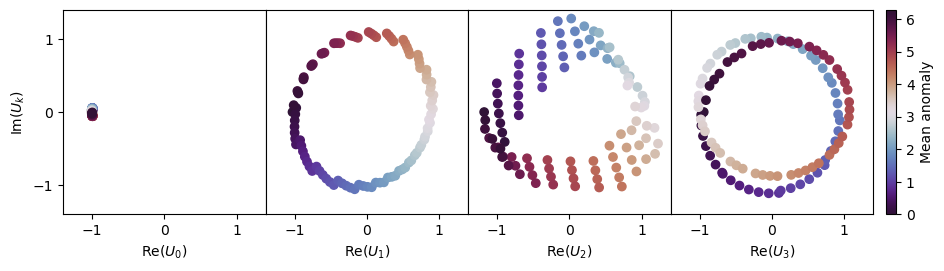

In [11]:
# Make plot
n_comp = 4
lim = 1.4
f = plt.figure(figsize=(6.4*1.5, 3.75*0.75))
widths = np.ones(n_comp)
widths[-1] += 0.25
f.subplots(1, n_comp, gridspec_kw={'width_ratios': widths, 'wspace': 0}, sharey=True)
colors = np.linspace(0, 2*np.pi, 100, endpoint=False)
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)
    plt.scatter(np.real(U[i])*10, np.imag(U[i])*10, c=colors, vmin=0, vmax=2*np.pi, cmap='twilight_shifted')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel(r'Re($U_%d$)' % i)
    if i == 0:
        plt.ylabel('Im($U_k$)')
    else:
        plt.gca().get_yaxis().set_visible(False)

# Plot formatting
plt.yticks([-1,0,1])
plt.colorbar(label='Mean anomaly')
plt.tight_layout()
plt.savefig('Figures/SVD100_4hcoeffs.png', dpi=450)

## Comparing to our waveforms

We can now compare the h0, h1, etc. waveforms we have built to the SVD harmonics found here by calculating the overlap between them.

In [12]:
# Convert SVD harmonics to pycbc timeseries
unwhite_harms_ts = []
n_wfs = 8
for i in range(n_wfs):
    unwhite_harms_ts.append(timeseries.TimeSeries(unwhite_harms[i], 1/sample_rate, epoch=training_wfs[0].sample_times[0]))

# Generate our waveforms up to n=8
wf = {}
for n in range(2,9):
    wf[f'{n}_comp'] = list(get_h([1]*n, f_low, e, chirp2total(chirp, q), q, sample_rate))[1:n+1]

In [13]:
# Calculate matches
inds = [0, 1, -1, 2, 3, 4, 5, 6]
for n in range(2, n_wfs+1):
    for i in range(n):
        ovlp = np.abs(overlap_cplx_wfs(unwhite_harms_ts[i], wf['%d_comp' % n][i], 10))
        print('h{}, n={:d} waveform overlap with SVD100: {:.4f}'.format(inds[i], n, ovlp))
    print('\n')

h0, n=2 waveform overlap with SVD100: 0.9963
h1, n=2 waveform overlap with SVD100: 0.9225


h0, n=3 waveform overlap with SVD100: 0.9996
h1, n=3 waveform overlap with SVD100: 0.9949
h-1, n=3 waveform overlap with SVD100: 0.8050


h0, n=4 waveform overlap with SVD100: 0.9991
h1, n=4 waveform overlap with SVD100: 0.9995
h-1, n=4 waveform overlap with SVD100: 0.9618
h2, n=4 waveform overlap with SVD100: 0.9946


h0, n=5 waveform overlap with SVD100: 0.9996
h1, n=5 waveform overlap with SVD100: 0.9993
h-1, n=5 waveform overlap with SVD100: 0.9917
h2, n=5 waveform overlap with SVD100: 0.9957
h3, n=5 waveform overlap with SVD100: 0.9668


h0, n=6 waveform overlap with SVD100: 1.0000
h1, n=6 waveform overlap with SVD100: 0.9995
h-1, n=6 waveform overlap with SVD100: 0.9908
h2, n=6 waveform overlap with SVD100: 0.9621
h3, n=6 waveform overlap with SVD100: 0.9701
h4, n=6 waveform overlap with SVD100: 0.8400


h0, n=7 waveform overlap with SVD100: 0.9999
h1, n=7 waveform overlap with SVD100: 0.9